# Predicting Pokemon Types from Images and Statistics

Scott Ratchford, (c) 2025

See `LICENSE.txt` for license information.

In [72]:
# Set paths to data files and directories

import os
import pandas as pd
import numpy as np

CWD = os.getcwd()

# Input paths for data (modify as required)
PKMN_IMG_ALT_DIR = os.path.join(CWD, "data", "pokemon_images_alt", "images")                    # Directory containing all Pokemon images
POKEDEX_ALT_PATH = os.path.join(CWD, "data", "pokemon_images_alt", "pokedex_alt_modified.csv")  # .csv file from "Pokemon with Stats and Images"
PKMN_STATS_PATH = os.path.join(CWD, "data", "pokemon_stats.csv")                                # .csv file from "Pokemon Pokedex"

# Output paths for created and modified data (modify as required)
PKMN_IMG_COLORS_ALT_PATH = os.path.join(CWD, "pokemon_colors_alt.csv")              # Pokemon color data output
PKMN_IMG_COLORS_ALT_TRAIN_PATH = os.path.join(CWD, "pokemon_colors_alt_train.csv")  # Pokemon color training data output
PKMN_IMG_COLORS_ALT_TEST_PATH = os.path.join(CWD, "pokemon_colors_alt_test.csv")    # Pokemon color testing data output

RNG_SEED = 151

TEST_SIZE = 0.2

In [73]:
# Import in-game statistics dataset
pkmn_stats = pd.read_csv(POKEDEX_ALT_PATH, encoding="utf-8")
pkmn_stats["Name"] = pkmn_stats["Name"].apply(lambda x: x.lower())
print(f"PKMN stats rows: {pkmn_stats.shape[0]}")
print(f"PKMN stats columns: {list(pkmn_stats.columns)}")

pkmn_color_df = pd.read_csv(PKMN_IMG_COLORS_ALT_PATH, encoding="utf-8", index_col=0)
print(f"PKMN color rows: {pkmn_color_df.shape[0]}")
print(f"PKMN colors columns: {list(pkmn_color_df.columns)}")

PKMN stats rows: 1215
PKMN stats columns: ['Index', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense', 'SP. Atk.', 'SP. Def', 'Speed', 'Ignore', 'Filename']
PKMN color rows: 959
PKMN colors columns: ['Name', 'Type 1', 'Type 2', 'Filename', 'Number', 'Train', 'aqua', 'black', 'blue', 'fuchsia', 'green', 'gray', 'lime', 'maroon', 'navy', 'olive', 'purple', 'red', 'silver', 'teal', 'white', 'yellow']


In [74]:
pkmn_stats = pd.merge(pkmn_stats, pkmn_color_df[["Name", "Number", "Train"]], on=["Name", ], how="inner")

In [75]:
pkmn_stats.head(1)

,Index,Name,Type 1,Type 2,Total,HP,Attack,Defense,SP. Atk.,SP. Def,Speed,Ignore,Filename,Number,Train
0,0,bulbasaur,Grass,Poison,318,45,49,49,65,65,45,False,1.png,1,True


In [76]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Drop columns that provide too much or unneeded information about the Pokemon
drop_cols = ["Name", "Ignore", "Type 2", "Filename", "Number", ]
target_cols = ["Type 1", ]

# Encode type strings (to ints)
type_label_encoder = LabelEncoder()
pkmn_stats["Type 1"] = type_label_encoder.fit_transform(pkmn_stats["Type 1"])
pkmn_stats["Type 1"] = pkmn_stats["Type 1"].astype(dtype=int)
# pkmn_stats["Type 2"] = type_label_encoder.fit_transform(pkmn_stats["Type 2"])
# pkmn_stats["Type 2"] = pkmn_stats["Type 2"].astype(dtype=int)

pkmn_stats_train = pkmn_stats[pkmn_stats["Train"] == True]
pkmn_stats_train = pkmn_stats_train.drop(labels=["Train", ], axis=1)
pkmn_stats_test = pkmn_stats[pkmn_stats["Train"] == False]
pkmn_stats_test = pkmn_stats_test.drop(labels=["Train", ], axis=1)

X_train = pkmn_stats_train.drop(labels=(drop_cols + target_cols), axis=1)
y_train = pkmn_stats_train[target_cols]
X_test = pkmn_stats_test.drop(labels=(drop_cols + target_cols), axis=1)
y_test = pkmn_stats_test[target_cols]

print("Split Pokemon statistics into training and testing.")

Split Pokemon statistics into training and testing.


In [77]:
# Create the KNN model for in-game statistics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_stats_model = KNeighborsClassifier()
# hyperparameters to try
knn_hyperparameters = {
    "n_neighbors": range(3, 11),
    "leaf_size": range(10, 41),
    "p": range(1, 4),
    "weights": ("distance", "uniform", ),
    "algorithm": ("kd_tree", "ball_tree", ),
}

knn_clf = GridSearchCV(knn_stats_model, knn_hyperparameters, n_jobs=-1)

knn_stats_model = knn_clf.fit(X_train, y_train.values.ravel())

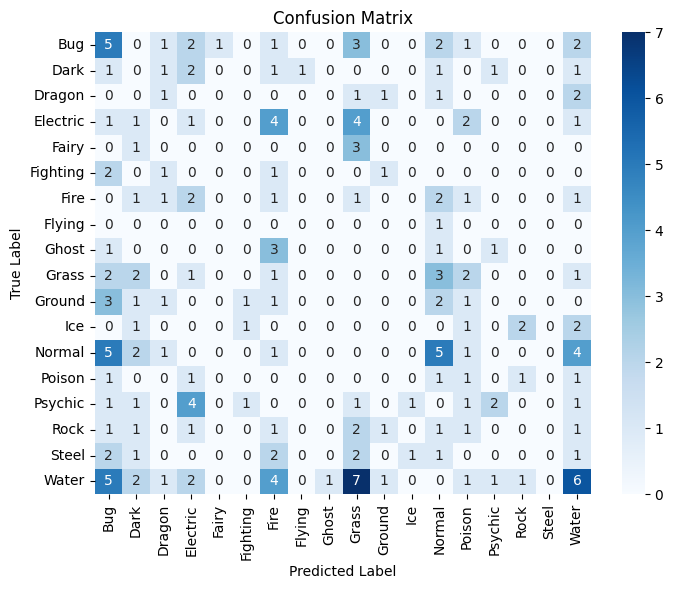

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

knn_stats_pred = knn_clf.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, knn_stats_pred)

# Get the unique encoded labels from the true labels
labels_encoded = np.unique(y_test)
# Use the previously defined and fitted type_label_encoder to decode labels
labels = type_label_encoder.inverse_transform(labels_encoded)

# Create the heatmap visualization with the decoded labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [79]:
# # Match test data with original data to find names and types
# pkmn_stats.reset_index()
# knn_pred_df = pd.DataFrame(knn_stats_pred, columns=["Type 1 Prediction"])
# knn_pred_df["Type 1 Prediction"] = type_label_encoder.inverse_transform(knn_pred_df["Type 1 Prediction"])
# knn_pred_df.reset_index()

# # join knn pred with X_test on index
# x_test_and_knn_pred = pd.merge(X_test, knn_pred_df, how="inner", left_index=True, right_index=True, validate="1:1")
# # join that result to pkmn_stats to find predicted type
# join_on = ["Number", "Total", "HP", "Attack", "Defense", "SP. Atk", "SP. Def", "Speed", ]
# rejoined_data = pd.merge(pkmn_stats, x_test_and_knn_pred, how="inner", left_on=join_on, right_on=join_on, validate="1:1")

## Images

In [80]:
import os

CWD = os.getcwd()

# Set Pokemon image input and output paths
DATASET_DIR = os.path.join(CWD, "data", "pokemon_images", "dataset")
TRAIN_IMG_DIR = os.path.join(CWD, "data", "pokemon_images", "train_images")
TEST_IMG_DIR = os.path.join(CWD, "data", "pokemon_images", "test_images")

# Set Pokemon color output path
PKMN_IMG_COLORS_ALT_PATH = os.path.join(CWD, "pokemon_colors_alt.csv")

### Import In-Game Statistics

### Load Pokemon Color Data from Files

In [81]:
pkmn_color_df = pd.read_csv(PKMN_IMG_COLORS_ALT_PATH, sep=",", encoding="utf-8", index_col=0)

pkmn_color_train_df = pkmn_color_df[pkmn_color_df["Train"] == True]
pkmn_color_test_df = pkmn_color_df[pkmn_color_df["Train"] == False]

print(f"Color data for {pkmn_color_train_df.shape[0]} testing Pokemon loaded.")
print(f"Color data for {pkmn_color_test_df.shape[0]} testing Pokemon loaded.")

Color data for 767 testing Pokemon loaded.
Color data for 192 testing Pokemon loaded.


In [82]:
def sample_min_entries(df: pd.DataFrame, target_col: str, min_entries: int, random_state=42):
    """
    Returns a new DataFrame containing a random subset such that
    each unique value in target_col is represented with at least min_entries entries,
    or all entries if there are less than min_entries available.
    
    Parameters:
    - df: Original DataFrame.
    - min_entries: Minimum number of entries to sample from each group.
    - random_state: Seed for reproducibility.
    """
    # Group by target_col and sample n=min(len(group), min_entries) rows from each group.
    return df.groupby(target_col, group_keys=False).apply(
        lambda group: group.sample(n=min(len(group), min_entries), random_state=random_state), include_groups=True
    )

In [83]:
# Adjust data to provide equivalent amounts for each type
types_train = {color: pkmn_color_train_df[pkmn_color_train_df["Type 1"] == color].shape[0] for color in pkmn_color_train_df["Type 1"].unique()}
least_train = min(types_train.values())
most_train = max(types_train.values())
pkmn_color_train_df_edited = sample_min_entries(pkmn_color_train_df, "Type 1", most_train)    # least_train

types_test = {color: pkmn_color_test_df[pkmn_color_test_df["Type 1"] == color].shape[0] for color in pkmn_color_test_df["Type 1"].unique()}
least_test = min(types_test.values())
most_test = max(types_test.values())
pkmn_color_test_df_edited = sample_min_entries(pkmn_color_test_df, "Type 1", most_test)   # least_test

C:\Users\Scott\AppData\Local\Temp\ipykernel_16944\251377683.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(target_col, group_keys=False).apply(
C:\Users\Scott\AppData\Local\Temp\ipykernel_16944\251377683.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(target_col, group_keys=False).apply(


### Label and Scale Data

In [84]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

drop_color_cols = []
# Drop columns that provide too much information about the Pokemon
drop_color_cols.extend(["Name", "Number", "Filename", ])
# Drop other columns
drop_color_cols.extend(["Type 2", "Train", ])
# Drop columns containing target information
drop_color_cols.extend(["Type 1", ])

X_colors_train = pkmn_color_train_df_edited.drop(labels=drop_color_cols, axis=1)
X_colors_test = pkmn_color_test_df_edited.drop(labels=drop_color_cols, axis=1)
y_colors_train = pkmn_color_train_df_edited[["Type 1"]].copy()
y_colors_test = pkmn_color_test_df_edited[["Type 1"]].copy()

# Encode type strings to ints
type_label_encoder = LabelEncoder()
y_colors_train["Type 1"] = type_label_encoder.fit_transform(y_colors_train["Type 1"])
y_colors_train["Type 1"] = y_colors_train["Type 1"].astype(dtype=int)
y_colors_test["Type 1"] = type_label_encoder.fit_transform(y_colors_test["Type 1"])
y_colors_test["Type 1"] = y_colors_test["Type 1"].astype(dtype=int)
# y_colors_train["Type 2"] = type_label_encoder.fit_transform(y_colors_train["Type 2"])
# y_colors_train["Type 2"] = y_colors_train["Type 2"].astype(dtype=int)
# y_colors_test["Type 2"] = type_label_encoder.fit_transform(y_colors_test["Type 2"])
# y_colors_test["Type 2"] = y_colors_test["Type 2"].astype(dtype=int)

# Scale color data
color_cols = [
    'aqua', 'black', 'blue', 'fuchsia', 'green', 'gray', 'lime', 'maroon',
    'navy', 'olive', 'purple', 'red', 'silver', 'teal', 'white', 'yellow'
]
scaler = StandardScaler()
X_colors_train[color_cols] = scaler.fit_transform(X_colors_train[color_cols])
X_colors_test[color_cols] = scaler.fit_transform(X_colors_test[color_cols])

### Pokemon Colors KNN

In [85]:
# Create the KNN model for colors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_colors_model = KNeighborsClassifier()
# hyperparameters to try
knn_hyperparameters = {
    "n_neighbors": range(15, 31),
    "leaf_size": range(10, 31),
    "p": range(1, 4),
    "weights": ("distance", ),  # "uniform", 
    "algorithm": ("kd_tree", ), # "ball_tree", 
    "metric": ("minkowski", "chebyshev", ),
}

knn_colors_clf = GridSearchCV(knn_colors_model, knn_hyperparameters, n_jobs=-1)
knn_colors_model = knn_colors_clf.fit(X_colors_train, y_colors_train.values.ravel())

print(knn_colors_clf.best_params_)

{'algorithm': 'kd_tree', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 23, 'p': 1, 'weights': 'distance'}


In [86]:
# import pickle

# # Save model to file
# with open(os.path.join(CWD, "models", "knn_colors_clf.pickle"), "wb") as f:
#     pickle.dump(knn_colors_clf, f, protocol=pickle.HIGHEST_PROTOCOL)

In [87]:
from sklearn.metrics import accuracy_score

knn_color_pred = knn_colors_clf.predict(X_colors_test)

accuracy = accuracy_score(y_colors_test, knn_color_pred)
print(f"Accuracy: {accuracy}, Test Error: {1-accuracy}")
print(f"{accuracy * y_colors_test.shape[0]:.0f} out of {y_colors_test.shape[0]} correctly predicted")

Accuracy: 0.2552083333333333, Test Error: 0.7447916666666667
49 out of 192 correctly predicted


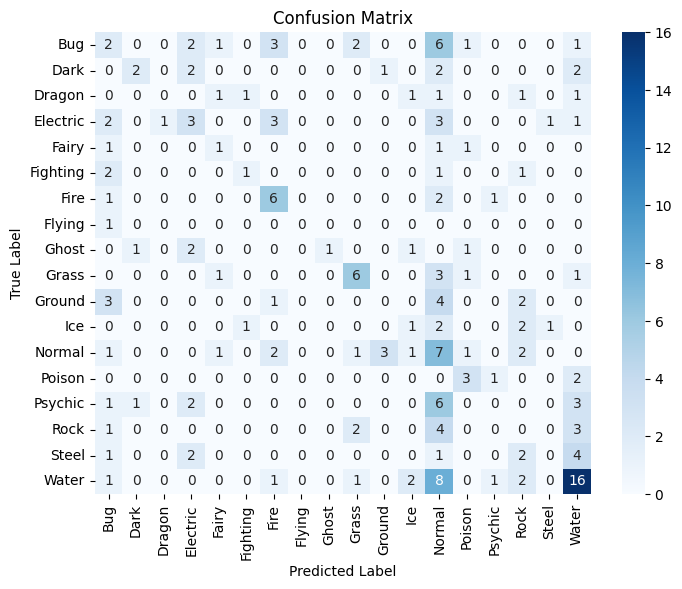

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_colors_test, knn_color_pred)

# Get the unique encoded labels from the true labels
labels_encoded = np.unique(y_colors_test)
# Use the previously defined and fitted type_label_encoder to decode labels
labels = type_label_encoder.inverse_transform(labels_encoded)

# Create the heatmap visualization with the decoded labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

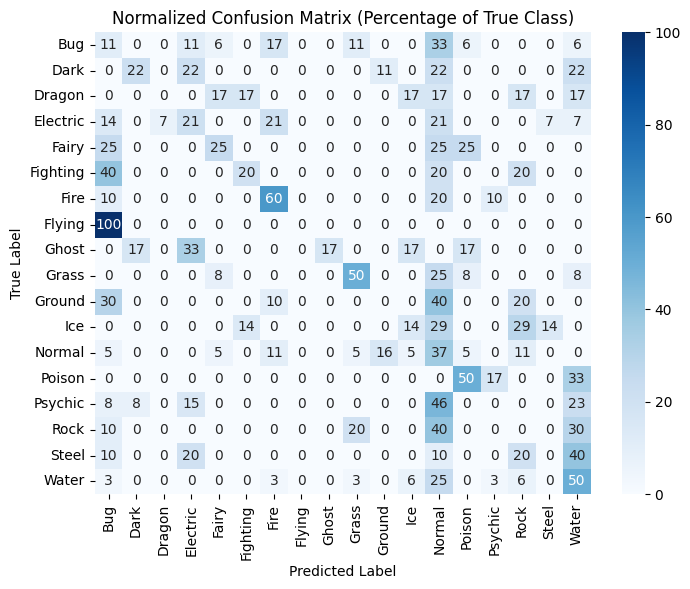

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_colors_test, knn_color_pred)

# Normalize the confusion matrix by the true labels (i.e. each row)
cm_normalized = cm.astype(int) / cm.sum(axis=1)[:, np.newaxis]

# Retrieve the original class labels using the fitted label encoder
labels_encoded = np.unique(y_colors_test)
labels = type_label_encoder.inverse_transform(labels_encoded)

# Create the heatmap using the normalized percentages (multiplied by 100)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized * 100, annot=True, fmt=".0f", cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix (Percentage of True Class)')
plt.show()

### Pokemon Colors RF

In [ ]:
# Create the KNN model for colors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf_colors_model = RandomForestClassifier()
# hyperparameters to try
rf_hyperparameters = {
    "n_estimators": range(200, 550, 50),
    "min_samples_split": (10, ),
    "max_depth": range(10, 45, 5),
    "random_state": (RNG_SEED, ),
}

rf_colors_clf = GridSearchCV(rf_colors_model, rf_hyperparameters, n_jobs=-1)
rf_colors_clf = rf_colors_clf.fit(X_colors_train, y_colors_train.values.ravel())

print(rf_colors_clf.best_params_)

rf_colors_model = rf_colors_clf.best_estimator_

{'max_depth': 25, 'min_samples_split': 10, 'n_estimators': 350, 'random_state': 151}


In [91]:
# import pickle

# # Save model to file
# with open(os.path.join(CWD, "models", "rf_colors_clf.pickle"), "wb") as f:
#     pickle.dump(rf_colors_clf, f, protocol=pickle.HIGHEST_PROTOCOL)

In [92]:
from sklearn.metrics import accuracy_score

rf_color_pred = rf_colors_clf.predict(X_colors_test)

accuracy = accuracy_score(y_colors_test, rf_color_pred)
print(f"Accuracy: {accuracy}, Test Error: {1-accuracy}")
print(f"{accuracy * y_colors_test.shape[0]:.0f} out of {y_colors_test.shape[0]} correctly predicted")

Accuracy: 0.3020833333333333, Test Error: 0.6979166666666667
58 out of 192 correctly predicted


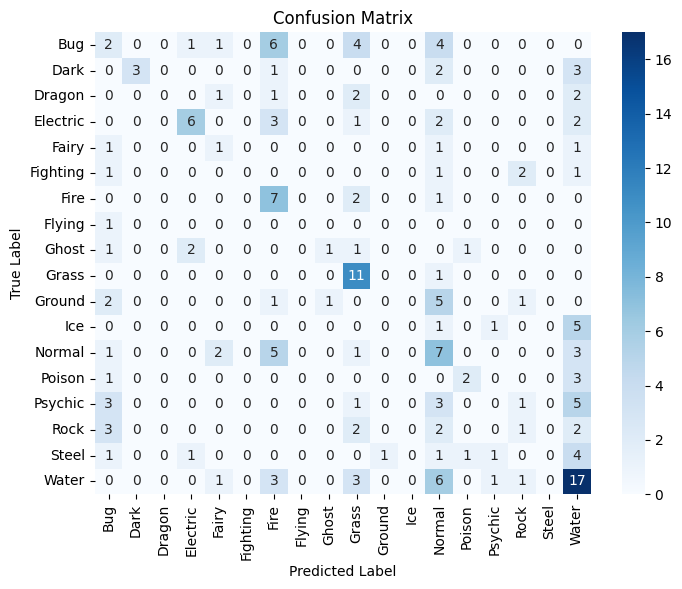

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_colors_test, rf_color_pred)

# Get the unique encoded labels from the true labels
labels_encoded = np.unique(y_colors_test)
# Use the previously defined and fitted type_label_encoder to decode labels
labels = type_label_encoder.inverse_transform(labels_encoded)

# Create the heatmap visualization with the decoded labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

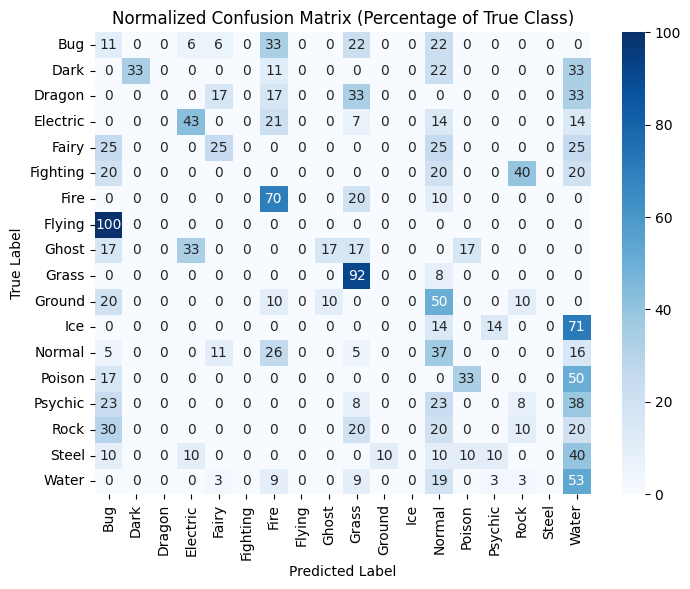

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_colors_test, rf_color_pred)

# Normalize the confusion matrix by the true labels (i.e. each row)
cm_normalized = cm.astype(int) / cm.sum(axis=1)[:, np.newaxis]

# Retrieve the original class labels using the fitted label encoder
labels_encoded = np.unique(y_colors_test)
labels = type_label_encoder.inverse_transform(labels_encoded)

# Create the heatmap using the normalized percentages (multiplied by 100)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized * 100, annot=True, fmt=".0f", cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix (Percentage of True Class)')
plt.show()

In [95]:
from IPython.display import display, HTML

accuracy = accuracy_score(y_colors_test, rf_color_pred)
rf_color_eval = y_colors_test.copy()
rf_color_eval["Predicted Type"] = rf_color_pred

rf_color_eval["Type 1"] = type_label_encoder.inverse_transform(rf_color_eval["Type 1"])
rf_color_eval["Predicted Type"] = type_label_encoder.inverse_transform(rf_color_eval["Predicted Type"])

rf_color_eval = pd.merge(rf_color_eval, pkmn_color_test_df_edited.drop(["Type 1", ], axis=1), how="inner", left_index=True, right_index=True)
rf_color_eval["Correct"] = rf_color_eval.apply(lambda row: row["Predicted Type"] in (row["Type 1"], row["Type 2"]), axis=1)

# Compute the overall accuracy.
either_accuracy = rf_color_eval["Correct"].mean()
print(f"Either type accuracy: {either_accuracy}")

Either type accuracy: 0.359375
